In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
IMG_SIZE = 250
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

### [ 수정사항 ]

### IMG_SIZE 150 >> 200
### IMG_SIZE 200 >> 250

In [4]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = "drive/MyDrive/Data/chest_xray"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train = get_training_data(os.path.join(DATA_DIR, 'train'))
test = get_training_data(os.path.join(DATA_DIR, 'test'))
val = get_training_data(os.path.join(DATA_DIR, 'val'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


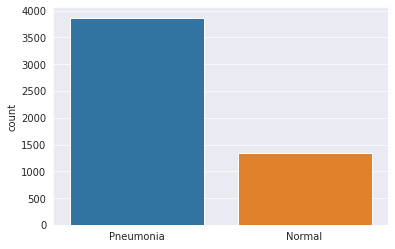

In [6]:
l = []
for i in train:
    if i[1] == 0:
        l.append("Pneumonia")
    else:
        l.append("Normal")
        
sns.set_style('darkgrid')
sns.countplot(l)        

Text(0.5, 1.0, 'NORMAL')

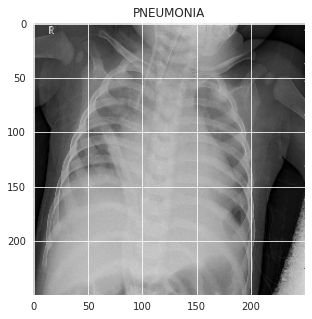

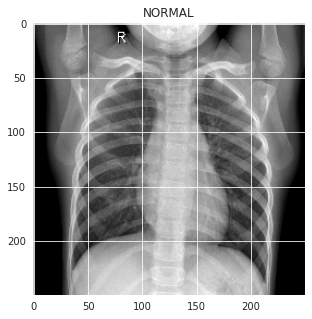

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [8]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [9]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [10]:
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

In [11]:

datagen = ImageDataGenerator(
        featurewise_center=False,              
        samplewise_center=False,               
        featurewise_std_normalization=False,   
        samplewise_std_normalization=False,    
        width_shift_range=0.1,                 
        height_shift_range=0.1) 


datagen.fit(x_train)

In [12]:
model = Sequential()
model.add(Conv2D(32, (5,5), strides=1, padding='same', activation='relu', input_shape=(250,250,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((5,5), strides=2 , padding='same'))
model.add(Conv2D(64, (5,5), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((5,5), strides=2, padding='same'))
model.add(Conv2D(64, (5,5), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((5,5), strides=2, padding='same'))
model.add(Conv2D(128, (5,5), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((5,5), strides=2, padding='same'))
model.add(Conv2D(256, (5,5), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((5,5), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      832       
                                                                 
 batch_normalization (BatchN  (None, 250, 250, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      51264     
                                                                 
 dropout (Dropout)           (None, 125, 125, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     2

### [ 수정사항 ]

### Conv2D (2, 2) >> (4, 4)
### Conv2D (4, 4) >> (5, 5)
### MaxPool2D(4, 4) >> (5, 5)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1,factor=0.3, min_lr=0.000001)

### [ 수정사항 ]

### batch_size 32 >> 40
### batch_size 40 >> 48
### EPOCHS 25 >> 20
### batch_size 48 >> 40

In [14]:
EPOCHS = 20
history = model.fit(datagen.flow(x_train, y_train, batch_size = 40), epochs = EPOCHS, validation_data = datagen.flow(x_val, y_val), callbacks = [learning_rate_reduction])

Epoch 1/20
131/131 [==============================] - 34s 215ms/step - loss: 1.7238 - accuracy: 0.8372 - val_loss: 60.9586 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 27s 206ms/step - loss: 0.2832 - accuracy: 0.8985 - val_loss: 199.9645 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.1730 - accuracy: 0.9342
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 27s 205ms/step - loss: 0.1730 - accuracy: 0.9342 - val_loss: 26.8586 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 27s 205ms/step - loss: 0.0893 - accuracy: 0.9685 - val_loss: 74.6453 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/20
131/131 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9702
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
131/131 [=================

In [15]:
loss, acc = model.evaluate(x_test,y_test)
print("Loss of the model is -", loss)
print("Accuracy of the model is -", acc * 100)

20/20 [==============================] - 2s 36ms/step - loss: 1.4390 - accuracy: 0.8205
Loss of the model is - 1.4389591217041016
Accuracy of the model is - 82.05128312110901


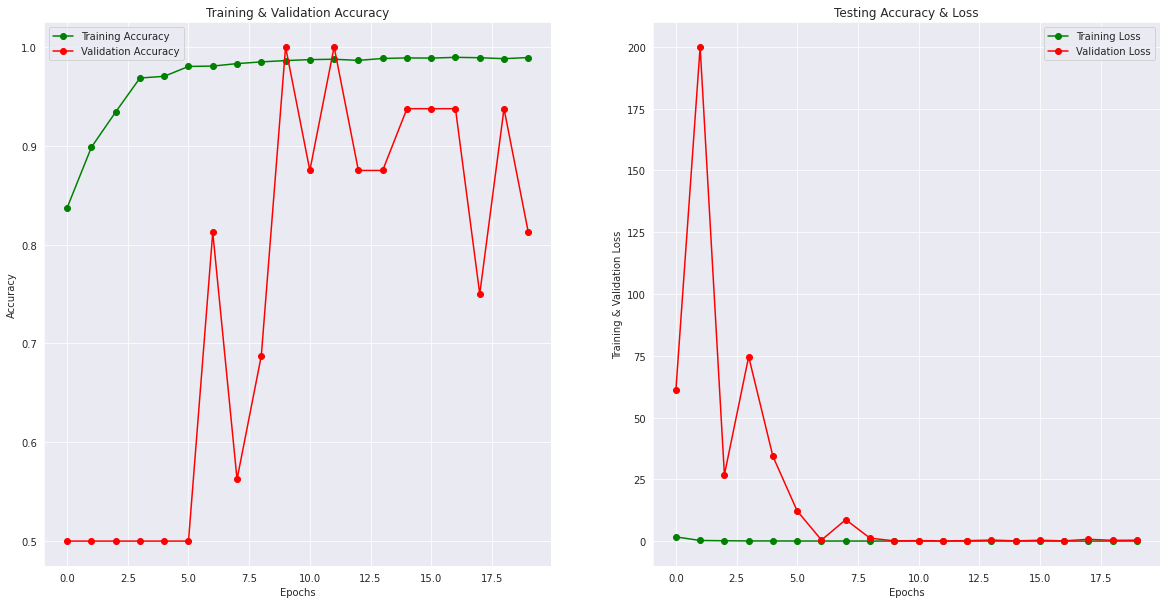

In [16]:
epochs = list(range(EPOCHS))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [17]:
predicted = (model.predict(x_test) > 0.5).astype("int32")
predictions = predicted.reshape(1,-1)[0]

predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [18]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.78      0.99      0.87       390
   Normal (Class 1)       0.98      0.53      0.69       234

           accuracy                           0.82       624
          macro avg       0.88      0.76      0.78       624
       weighted avg       0.86      0.82      0.80       624



In [19]:
cm = confusion_matrix(y_test,predictions)
cm

array([[388,   2],
       [110, 124]])

In [20]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

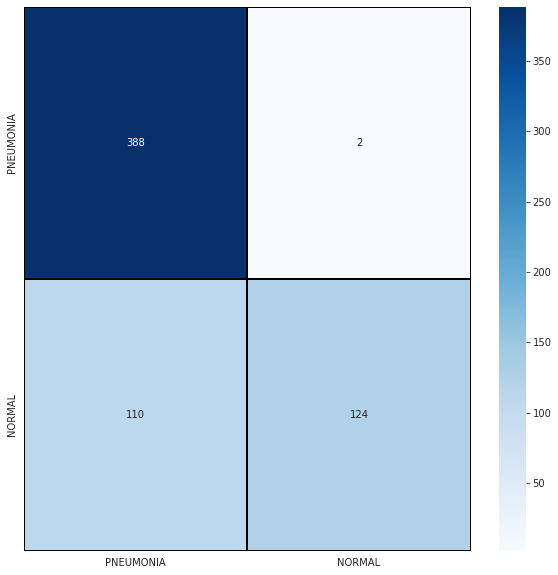

In [21]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [22]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

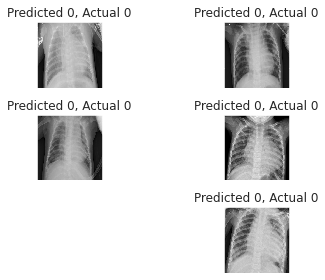

In [23]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(250,250), cmap="gray", interpolation='none')
    plt.title("Predicted {}, Actual {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

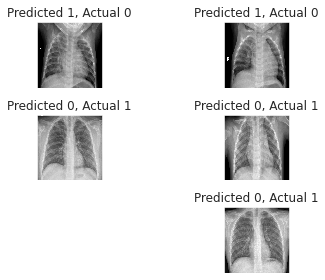

In [24]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(250,250), cmap="gray", interpolation='none')
    plt.title("Predicted {}, Actual {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1